In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import matplotlib.pyplot as plt
#importing libraries

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [2]:
final_df = pd.read_csv("./data_cleaned/final_df.csv")
final_df.rename(columns = {"Unnamed: 0":"date"},inplace=True)
final_df.set_index(final_df["date"],inplace=True)
final_df.drop(columns = ["date"],inplace=True)

In [3]:
df = final_df.copy()


In [4]:
df.columns

Index(['CPI', 'employees_construction', 'GDP', 'HCAI_GOVT', 'HCAI_GSE',
       'HCAI_PP', 'home-ownership-rate', 'industrial_production_cement', '0',
       'MORTGAGE30US', 'pvt_owned_house_under_const',
       'nonresidential_const_val', 'permits', 'house_units_completed',
       'producer_price_index_concrete_brick', 'residential_const_val',
       'retail_sales_home_furnishing_stores', 'target', 'UNRATE',
       'unrate_construction'],
      dtype='object')

### CPI above 0 or below 0

In [6]:
# Adding a categorical variable to gauge CPI TREND
df["CPI_TREND"] = df["CPI"].apply(lambda x : "UP" if x > 0 else "DOWN")
df["CPI_TREND"].value_counts()

CPI_TREND
UP      170
DOWN     70
Name: count, dtype: int64

### Growth in GDP - past 12 months

In [7]:

df["GDP_RATE"] = np.log(df["GDP"]/df["GDP"].shift(12))


## GDP trend

In [8]:
# Adding a categorical variable to gauge GDP TREND
df["GDP_TREND"] = df["GDP_RATE"].apply(lambda x : "UP" if x > 0 else "DOWN")

## Growth in number of construction employees

In [9]:
df["EMP_CONST_RATE"] = np.log(df["employees_construction"]/df["employees_construction"].shift(12))

## Trend in number of employees construction

In [10]:
# Adding a categorical variable to gauge trend in number of construction employees
df["EMP_CONST_TREND"] = df["EMP_CONST_RATE"].apply(lambda x : "UP" if x > 0 else "DOWN")

In [11]:
# Since HCAI_GOVT, HCAI_GSE AND HCAI_PP are highly collinear with each other, we are linearly combining them 
df["HCAI"] = (df["HCAI_GOVT"] + df["HCAI_GSE"] + df["HCAI_PP"])/3


### Analyzing correlation with derivates of features

In [14]:
for column in df.columns:
    try:
        temp_rate = np.log(df[column]/df[column].shift(12)).dropna()
        temp_cum = df[column].cumsum()
        
        temp_rate_cum = np.log(temp_cum/temp_cum.shift(12)).dropna()
        print()
        print(column,round(df.corr()["target"][column],2))
        trate12 = np.corrcoef(df["target"][12:],temp_rate)[0,1]
        print(f"Correlation between target variable and 12 months change of rate {round(trate12,2)}")
        
        tcum = (np.corrcoef(df["target"],temp_cum)[0,1])
        print(f"correlation cumulative {round(tcum,2) }")
        
        tcumrate = np.corrcoef(df["target"][12:],temp_rate_cum)[0,1]
        print(f"correlation cumulative rate {round(tcumrate,2) }")
        

        
    except:
        continue

* Feature engineering - ends

In [22]:
final_df = pd.get_dummies(final_df,drop_first=True).dropna()
train = final_df[:"2015"]
test = final_df["2016":]

trainx = train.loc[:,train.columns!="target"]
trainy = train["target"]

testx = test.loc[:,test.columns!="target"]
testy = test["target"]

X = trainx.copy()
y = trainy.copy()


<Axes: >

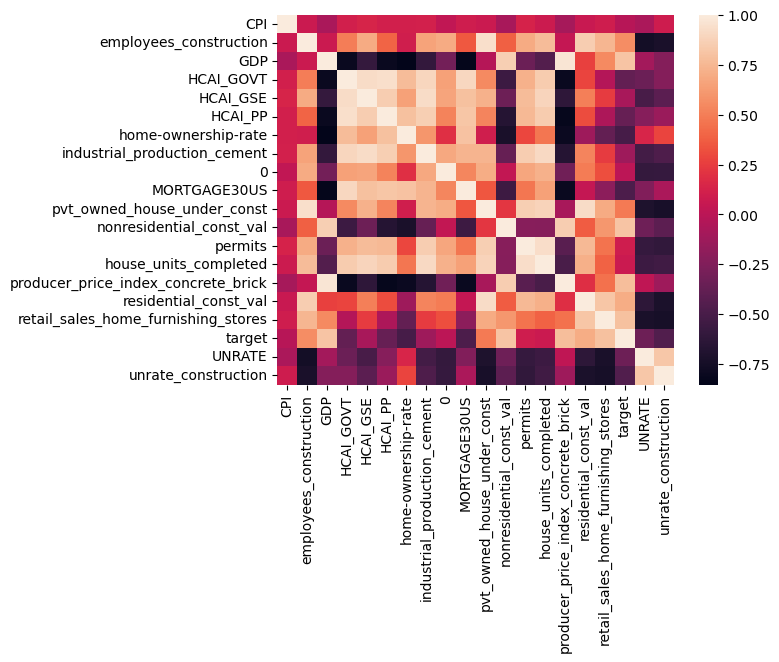

In [23]:
sns.heatmap(final_df.corr())

## Multicollinearity

* There exists a high correlation between independent variables, hence to use linear model, we have to use L1 regularization


#### Feature scaling

In [24]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [25]:
testx = scaler.transform(testx)

In [26]:
#Initializing lassoCV instance
reg = LassoCV()
# Fitting the instance
reg.fit(X, y)
print(f"Best alpha using built-in LassoCV: {round(reg.alpha_,5)}")

print(f"Best score using built-in LassoCV:{round(reg.score(testx,testy),4)}")

coef = pd.Series(reg.coef_, index = trainx.columns)

Best alpha using built-in LassoCV: 0.01471
Best score using built-in LassoCV:0.8776


#### Features selected by the model

In [27]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 18 variables and eliminated the other 1 variables


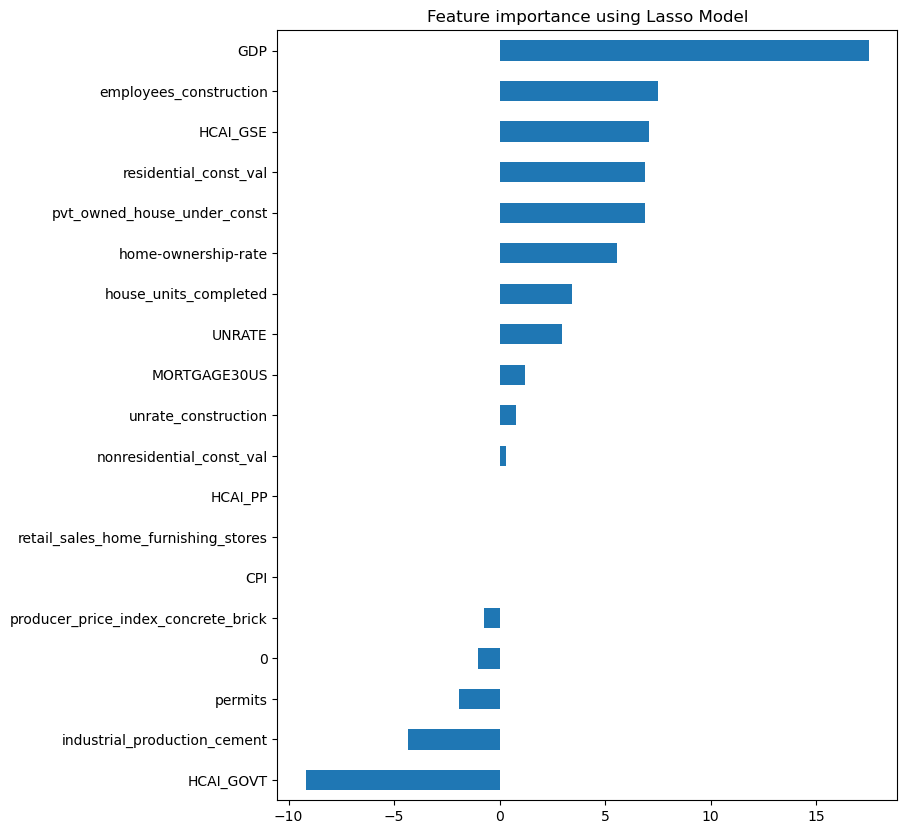

In [30]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Assuming you've already defined `imp_coef` and `coef` elsewhere in your code
imp_coef = coef.sort_values()

# Set the figure size
plt.rcParams['figure.figsize'] = (8.0, 10.0)

# Plot the feature importance using a horizontal bar plot
imp_coef.plot(kind="barh")
plt.title("Feature importance using Lasso Model")
plt.savefig("./images/featimp.png")  # Save the plot as an image
plt.show()  # Show the plot


## Features which gets eliminated

In [31]:
coef[coef==0]

retail_sales_home_furnishing_stores   -0.0
dtype: float64

### Features with non zero coefficients

In [32]:
((coef[coef!=0]).sort_values(ascending=False))

GDP                                    17.509377
employees_construction                  7.480795
HCAI_GSE                                7.065030
residential_const_val                   6.893283
pvt_owned_house_under_const             6.877930
home-ownership-rate                     5.578310
house_units_completed                   3.426091
UNRATE                                  2.948368
MORTGAGE30US                            1.216927
unrate_construction                     0.770582
nonresidential_const_val                0.298479
HCAI_PP                                 0.033141
CPI                                    -0.002938
producer_price_index_concrete_brick    -0.742633
0                                      -1.028260
permits                                -1.930239
industrial_production_cement           -4.330530
HCAI_GOVT                              -9.192179
dtype: float64

## Metrics

In [33]:
mse = mean_squared_error(reg.predict(testx),testy)
print(f" MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f" R2  = {round(reg.score(testx,testy),4)}")


 MSE = 26.737319559191242
RMSE = 5.170814206601436
 R2  = 0.8776


## Visualizing predictions

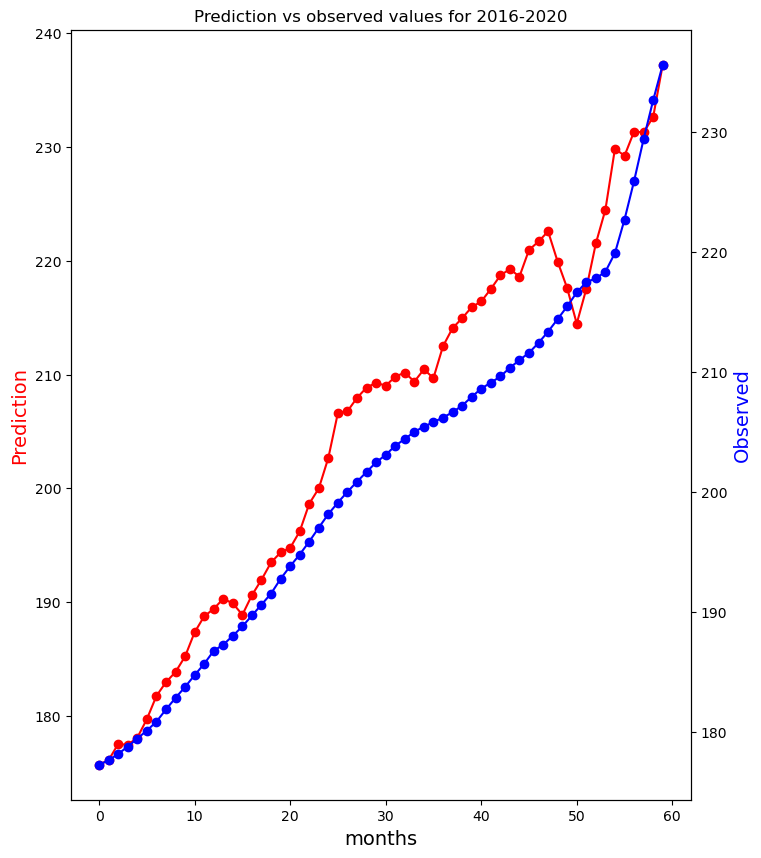

In [34]:

fig,ax = plt.subplots()
# make a plot
ax.plot(range(60), reg.predict(testx), color="red", marker="o")
# set x-axis label
ax.set_xlabel("months",fontsize=14)
# set y-axis label
ax.set_ylabel("Prediction",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(60),testy,color="blue",marker="o")
ax2.set_ylabel("Observed",color="blue",fontsize=14)
plt.title(label = "Prediction vs observed values for 2016-2020")
plt.show()
